Notebook to generate and plot DE Htmp of fibro effect on WT organoids

The aim is to compare and show no diffs between CD34 high and low fibroblasts (in terms of their effect on the transcriptional profile of WT organoids).


# Packages

In [1]:
library(tidyverse)
library(Seurat)
library(ComplexHeatmap)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching SeuratObject

Attaching sp

Loading required package: grid

ComplexHeatmap version 2.12.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This mess

# Data prep

In [2]:
INTepi <- readRDS("../RData/INTepi21_ucell.rds")
INTepi

An object of class Seurat 
84714 features across 29452 samples within 4 assays 
Active assay: RNA (27434 features, 0 variable features)
 3 other assays present: SCT, integrated, UCellRanks
 7 dimensional reductions calculated: pca, umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2

In [6]:
print(unique(INTepi@meta.data$curatedCLUST))
INTepi@meta.data %>% filter(orig.ident %in% c("monoWT","WTorg_mono","cocultWTFib","WTorg_CD34hilo","WTorg_CD34hi","WTorg_CD34lo")) %>% group_by(orig.ident) %>% summarise(n())

 [1] TA 1                  Goblet / DCS          Late Enterocyte      
 [4] Stem (Oncogene)       Early Enterocyte      Stem (Stroma)        
 [7] ER Stress             Stem                  TA 2                 
[10] Outlier 1 (Stressed?) Outlier 2 (CRC?)     
11 Levels: Stem Stem (Oncogene) Stem (Stroma) TA 1 TA 2 ... Outlier 2 (CRC?)


orig.ident,n()
<fct>,<int>
monoWT,779
WTorg_mono,736
cocultWTFib,1139
WTorg_CD34hilo,1610
WTorg_CD34hi,2474
WTorg_CD34lo,1372


In [8]:
INTepi <- subset(INTepi, 
                subset=curatedCLUST %in% c("TA 1","Goblet / DCS",
                    "Late Enterocyte","Stem (Oncogene)","Early Enterocyte",
                    "Stem (Stroma)","ER Stress","Stem","TA 2"
                                        )
                )
INTepi_fibWT <- subset(INTepi,
                    subset=orig.ident %in% c("monoWT","WTorg_mono",
                    "cocultWTFib","WTorg_CD34hilo","WTorg_CD34hi","WTorg_CD34lo"))
rm(INTepi)
INTepi_fibWT

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pca_epi_ to pcaepi_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from umap_epi_ to umapepi_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from phate_epi_ to phateepi_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from phate_epi2_ to phateepi2_”


An object of class Seurat 
84714 features across 8082 samples within 4 assays 
Active assay: RNA (27434 features, 0 variable features)
 3 other assays present: SCT, integrated, UCellRanks
 7 dimensional reductions calculated: pca, umap, phate, pca_epi, umap_epi, phate_epi, phate_epi2

In [10]:
print(unique(INTepi_fibWT@meta.data$orig.ident))
# INTfib@meta.data$orig.ident <- factor(
#                                 INTfib@meta.data$orig.ident,
#                                 levels= c(
#                                     "monoFib", 
#                                     "WTorg_CD34lo", "WTorg_CD34hi", 
#                                         "WTorg_CD34hilo", "cocultWTFib", 
#                                     "cocultAFib",
#                                     "cocultAKFib",
#                                     "cocultAKPFib",
#                                     "cocultMacFib",
#                                     "cocultWTMacFib","cocultAMacFib",
#                                     "cocultAKMacFib", "cocultAKPMacFib"
#                                 )
# )
levels(droplevels(INTepi_fibWT@meta.data$orig.ident))

[1] monoWT         cocultWTFib    WTorg_CD34hi   WTorg_CD34hilo WTorg_CD34lo  
[6] WTorg_mono    
21 Levels: monoWT WTorg_mono cocultWTMac cocultWTFib ... WTorg_WENR


[1] "monoWT"         "WTorg_mono"     "cocultWTFib"    "WTorg_CD34hilo"
[5] "WTorg_CD34hi"   "WTorg_CD34lo"

In [12]:
#Matrix
genelist <- c(
            # Cluster-based signatures
                #Stem (6):
            "Lgr5", "Pla2g2a", "Lrig1", "Smoc2", "Aqp5", "Agr2",
                ## Stem Oncogene:  (9) 
            "Cenpa", "Hmgb2", "Birc5", "Tuba1b", "Ube2c", "Rrm2", 
            "Hells", "Cdk1", "Ephb2",    
                ## Stem stroma: Revival! (18) #Removed Cxadr
            "Anxa1", "Ly6a", "Clu", "Basp1",  # Revival stem 
            "Areg", "Ccn1", "Ccn2", "Ankrd1",  # YAP Targets
            "Ctla2a", "Pmepa1", "Marcksl1", "Cldn4", "F3", "Ecm1", 
            "Sox9", "Cd44", "Itga2", "Fn1", # Broader 
                # Replication (TA?)(4)
            "Stmn1", "Ccnd1", "Mki67", "Ccnb1", 
                ## ER stress (4) #Removed Atf5
            "Hspa5", "Ddit3", "Atf3", "Atf4",
                # Epi niches
                ## Secretory (5)
            "Tff3", "Atoh1", "Muc2", "Spink4", "Reg4",  
                ## Absorptive (5)
            "Fabp2", "Aldob", "Apoa1", "Fabp1", "Apoa4", 
            # Condition-based signatures: 
                # WT / A (4)
            "Msln", "Lgals2", "Rps4l", "Gsta3",# !CRC
                # A/AK(P) (4)
            "Hopx", "pEGFP", # !WT 
            "Wfdc2", "Ly6c1" # CRC
)

mat_genelist <- INTepi_fibWT[["RNA"]]@scale.data[genelist,] %>% 
                as.matrix()

`use_raster` is automatically set to TRUE for a matrix with more than
2000 columns You can control `use_raster` argument by explicitly
setting TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



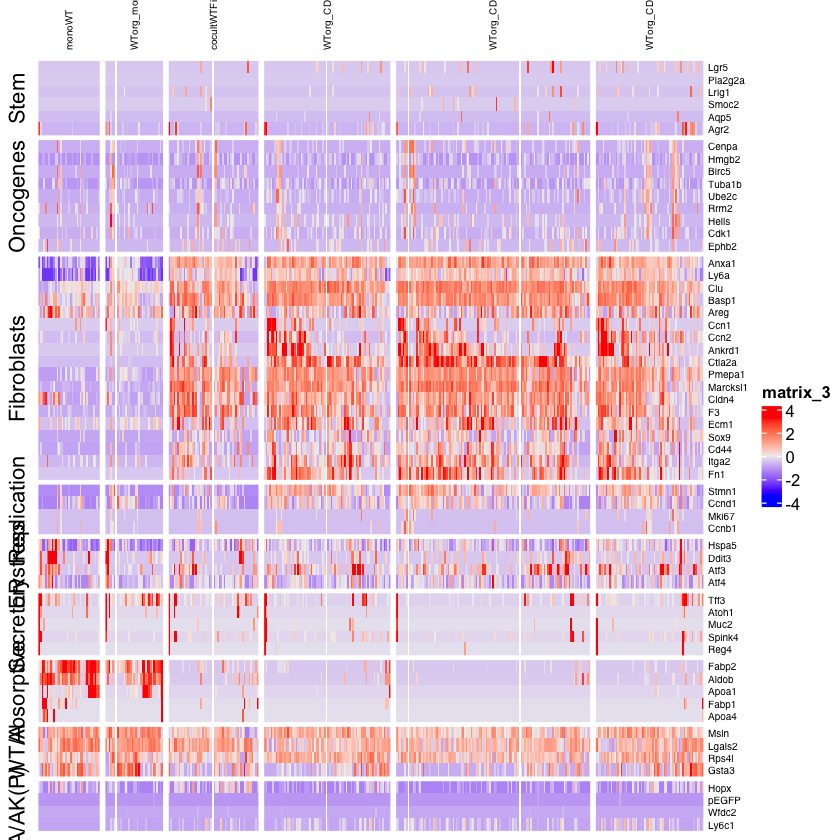

In [14]:
Heatmap(
        mat_genelist,
        column_split = INTepi_fibWT@meta.data$orig.ident,
        cluster_columns = TRUE, show_column_dend = FALSE, cluster_column_slices = FALSE,
        cluster_row_slices = FALSE, cluster_rows = FALSE,
        row_split = factor(
                        c(
                        rep("Stem", 6),
                        rep("Oncogenes", 9),
                        rep("Fibroblasts", 18),
                        rep("Replication", 4),
                        rep("ERstress", 4),
                        rep("Secretory", 5),
                        rep("Absorptive", 5),
                        rep("WT/A", 4),
                        rep("A/AK(P)", 4)
                        ),
                        levels = c(
                                "Stem","Oncogenes", "Fibroblasts", 
                                "Replication", "ERstress", 
                                "Secretory", "Absorptive",
                                "WT/A", "A/AK(P)"
                                )
                        ),
        row_names_gp = gpar(fontsize=6, fontfamily="Helvetica"),
        column_title_rot = 90, column_title_gp = gpar(fontsize=6),
        column_gap = unit(1.2, "mm"), show_column_names = FALSE
        )

Proper HTMP

In [15]:
palette_seqrun <- c(
                    "First"="#ae00ff",
                    "Second"="#ff0000"
                    )
palette_cd34hi <- c(
                    "0"="#FFFFFF",
                    "1"="#ffd000"
                    )
palette_cd34lo <- c(
                    "0"="#FFFFFF",
                    "1"="#66ff00"
                    )

In [24]:
mdSEQ <- INTepi_fibWT@meta.data %>%
                transmute(SEQ = case_when(
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_mono","WTorg_CD34lo", "WTorg_CD34hi", "WTorg_CD34hilo"
                    ) ~ "Second",
                    TRUE ~ "First"
                ))
mdSEQ %>% group_by(SEQ) %>% summarise(n())

SEQ,n()
<chr>,<int>
First,1918
Second,6164


In [18]:
mdCD34 <- INTepi_fibWT@meta.data %>%
                transmute(CD34hi = case_when(
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34hi", "WTorg_CD34hilo"
                    ) ~ "1",
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34lo"
                    ) ~ "0",
                                            ),
                CD34lo = case_when(
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34lo", "WTorg_CD34hilo"
                    ) ~ "1",
                    as.character.factor(orig.ident) %in% c(
                        "WTorg_CD34hi"
                    ) ~ "0",
                ))
mdCD34 %>% group_by(CD34hi, CD34lo) %>% summarise(n())

`summarise()` has grouped output by 'CD34hi'. You can override using the
`.groups` argument.


CD34hi,CD34lo,n()
<chr>,<chr>,<int>
0,1,1365
1,0,2464
1,1,1603
NA,NA,2650


In [25]:
INTepi_fibWT <- AddMetaData(INTepi_fibWT, metadata = c(mdSEQ, mdCD34))
head(INTepi_fibWT@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,mito_content,rfp_content,gfp_content,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,⋯,LGR5munoz_ALVAREZ22_UCell,FETALmustata_ALVAREZ22_UCell,MEX3Abarriga_ALVAREZ22_UCell,LGR5short_ALVAREZ22_UCell,MEX3A_ALVAREZ22_UCell,LGR5_ALVAREZ22_UCell,YAPsign_ALVAREZ22_UCell,SEQ,CD34hi,CD34lo
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
AAACGAAGTACTCAAC-1_1,monoWT,63438,5585,0.9757559,0,0,28180,4626,0.0107021193,-0.04948628,⋯,0.05392086,0.1949107,0.06091756,0,0.11914458,0.05791941,0.07133333,First,NA,NA
AAACGCTGTCAACCAT-1_1,monoWT,53897,5282,0.9314062,0,0,29372,4794,0.0131134354,-0.05278642,⋯,0.05806475,0.1258750,0.05990681,0,0.15837349,0.03807692,0.00000000,First,NA,NA
AAACGCTTCCTTGACC-1_1,monoWT,22699,3625,0.4008987,0,0,28022,3622,0.0002346597,-0.05661537,⋯,0.05561151,0.1055417,0.06203226,0,0.11769478,0.04440659,0.00000000,First,NA,NA
AAAGAACCACTGCATA-1_1,monoWT,14456,3433,1.0237963,0,0,27927,3563,0.0186447867,-0.04968890,⋯,0.05078897,0.1390357,0.05354122,0,0.09532932,0.06318681,0.08566667,First,NA,NA
AAAGGATAGGCATGCA-1_1,monoWT,29836,3841,1.2401126,0,0,28730,3840,0.0429923421,-0.06369078,⋯,0.05754436,0.0939881,0.05525090,0,0.11491165,0.04537729,0.00000000,First,NA,NA
AAAGGGCCATGCAGCC-1_1,monoWT,30720,4638,0.7552083,0,0,28907,4634,0.0382705618,-0.07844950,⋯,0.04887770,0.1994167,0.05356631,0,0.12681526,0.04914286,0.07379167,First,NA,NA


In [26]:
htmp_anno <- HeatmapAnnotation(
                SEQ = INTepi_fibWT@meta.data$SEQ,
                CD34hi = INTepi_fibWT@meta.data$CD34hi,
                CD34lo = INTepi_fibWT@meta.data$CD34lo,
                col=list(
                    SEQ = palette_seqrun,
                    CD34hi = palette_cd34hi,
                    CD34lo = palette_cd34lo
                ),
                na_col = "#FFFFFF"
)
htmp_anno

A HeatmapAnnotation object with 3 annotations
  name: heatmap_annotation_2 
  position: column 
  items: 8082 
  width: 1npc 
  height: 15.7029196070292mm 
  this object is subsettable
  15.1139333333333mm extension on the right 

   name annotation_type color_mapping height
    SEQ discrete vector  user-defined    5mm
 CD34hi discrete vector  user-defined    5mm
 CD34lo discrete vector  user-defined    5mm

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



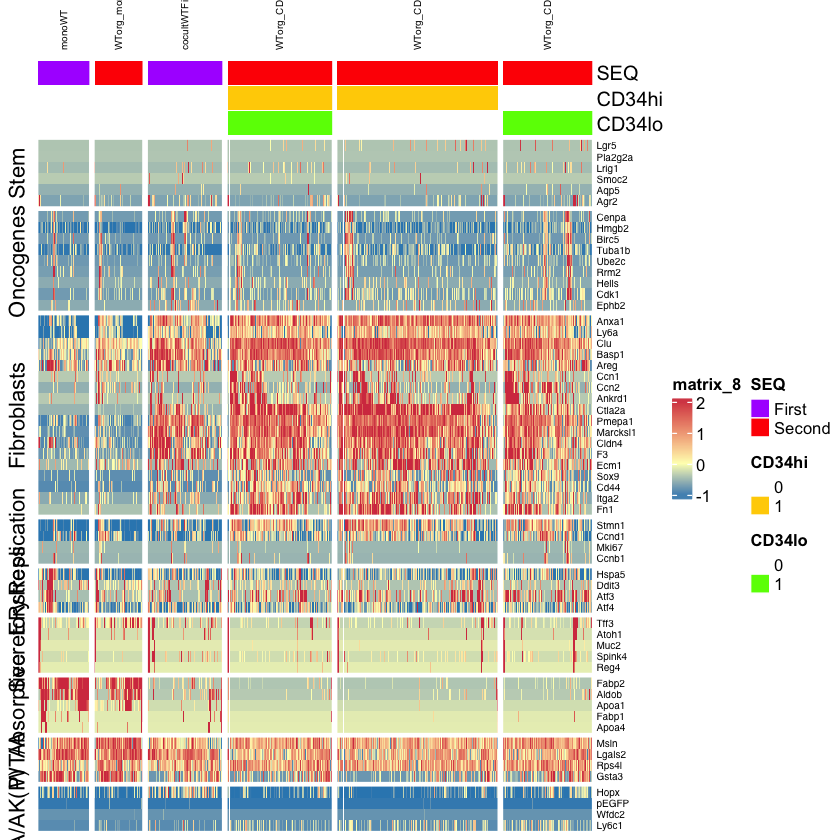

In [30]:
pHtmp_fibCD34_DEepi <- Heatmap(
        mat_genelist,
        column_split = INTepi_fibWT@meta.data$orig.ident,
        cluster_columns = TRUE, show_column_dend = FALSE, cluster_column_slices = FALSE,
        cluster_row_slices = FALSE, cluster_rows = FALSE,
        row_split = factor(
                        c(
                        rep("Stem", 6),
                        rep("Oncogenes", 9),
                        rep("Fibroblasts", 18),
                        rep("Replication", 4),
                        rep("ERstress", 4),
                        rep("Secretory", 5),
                        rep("Absorptive", 5),
                        rep("WT/A", 4),
                        rep("A/AK(P)", 4)
                        ),
                        levels = c(
                                "Stem","Oncogenes", "Fibroblasts", 
                                "Replication", "ERstress", 
                                "Secretory", "Absorptive",
                                "WT/A", "A/AK(P)"
                                )
                        ),
        row_names_gp = gpar(fontsize=6, fontfamily="Helvetica"),
        column_title_rot = 90, column_title_gp = gpar(fontsize=6),
        column_gap = unit(1.2, "mm"), show_column_names = FALSE,
        top_annotation = htmp_anno,
        use_raster = TRUE, raster_quality = 4,
        col=circlize::colorRamp2(
                c(round(quantile(mat_genelist, c(0.04,0.96))[1], digits = 1),
                0, 
                round(quantile(mat_genelist, c(0.04,0.96))[2], digits = 1)), 
                c("#3288BD", "#FEFEBD", "#D53E4F"))
        )

pHtmp_fibCD34_DEepi

# Save data

In [31]:
saveRDS(pHtmp_fibCD34_DEepi, "../RData/pHtmp_fibCD34_DEepi.rds")